In [1]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

import numpy as np
from functools import partial
import matplotlib
import matplotlib.pyplot as plt

import elfi

matplotlib.style.use('ggplot')
%matplotlib inline

# Using an external simulator with ELFI

ELFI supports using an external simulator and other operations that can be called from the command-line. This functionality is briefly introduced in this notebook. For a more concrete tutorial on ELFI and the MA2 model, please see the MA2 tutorial notebook.

Let's start by defining some constants:

In [2]:
n_obs = 100
t1_0 = 0.6
t2_0 = 0.2
random_state = np.random.RandomState(20161130)

Now we can set up a simulator as a **precompiled** executable that accepts command-line arguments. The placeholders for arguments in the command string will be replaced by ELFI using Python's [`format`](https://docs.python.org/3/library/string.html#formatstrings). If the simulator accepts a seed for random number generation, please use the name `seed`. In this case the number of observations, `n_obs`, is the last argument for the executable, but we set it already here using `partial`, so we give it the index 0.

In [3]:
# Set up the simulator (assume current dir is elfi/notebooks and ma2.bin compiled)
command = "../examples/cpp/ma2/ma2.bin {1} {2} {seed} {0}"
simulator = partial(elfi.Wrapper(command), n_obs)

Now the simulator can be run inside the Python interface. By default its output is read from `stdout` as a space-limited array that is converted into a numpy array. Custom parsers for both preprocessing and postprocessing may be given when initializing the `Wrapper`.

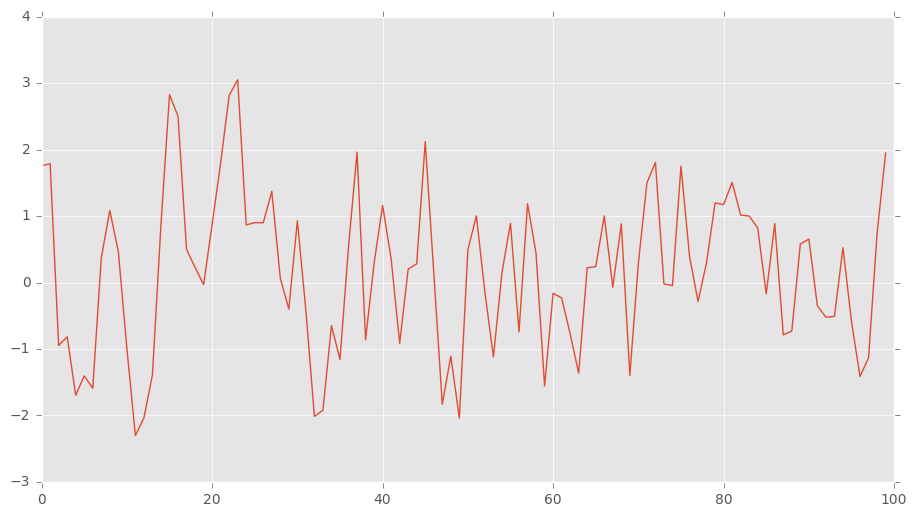

In [4]:
# Set up observed data y
y_obs = simulator(t1_0, t2_0, random_state=random_state)

# Plot
plt.figure(figsize=(11, 6));
plt.plot(y_obs.ravel());

Now we can continue with the definition of the Inference Task as usual:

In [5]:
from examples.ma2 import autocov, discrepancy

# Set up autocovariance summaries
ac1 = partial(autocov, lag=1)
ac2 = partial(autocov, lag=2)

# Specify the graphical model
t1 = elfi.Prior('t1', 'uniform', 0, 1)
t2 = elfi.Prior('t2', 'uniform', 0, 1)
Y = elfi.Simulator('MA2', simulator, t1, t2, observed=y_obs)
S1 = elfi.Summary('S1', ac1, Y)
S2 = elfi.Summary('S2', ac2, Y)
d = elfi.Discrepancy('d', discrepancy, S1, S2)

There are a couple of caveats in the wrapping operation. First, if the command-line operation does not accept vectorized arguments (like our simple `ma2.bin` here), one should run them sequentially. This can be accomplished by setting the `batch_size` to 1. Note that Dask may still run several operations in parallel.

Second, the wrapping operation itself has a relatively significant overhead. As you will see, the inference in this notebook seems very slow as compared to the pure Python case.

However, a typical use case of using an external operation is probably such that these overheads are insignificant in comparison with the run-time of the operation.

In [6]:
n_samples = 100  # very small for demonstration purposes only
batch_size = 1  # forces sequential running mode
rej = elfi.Rejection(d, [t1, t2], batch_size)

In [7]:
%time result = rej.sample(n_samples, quantile=0.1)

elfi.methods - INFO - Rejection: Running with 1000 proposals.


CPU times: user 54.5 s, sys: 8.21 s, total: 1min 2s
Wall time: 1min 3s


In [8]:
[t1_post, t2_post] = result['samples']
print("Number of accepted samples {} with threshold {:.2f}".format(len(t1_post), result['threshold']))
print("Posterior means: {:.2f} {:.2f}".format(t1_post.mean(), t2_post.mean()))

Number of accepted samples 100 with threshold 0.22
Posterior means: 0.65 0.24


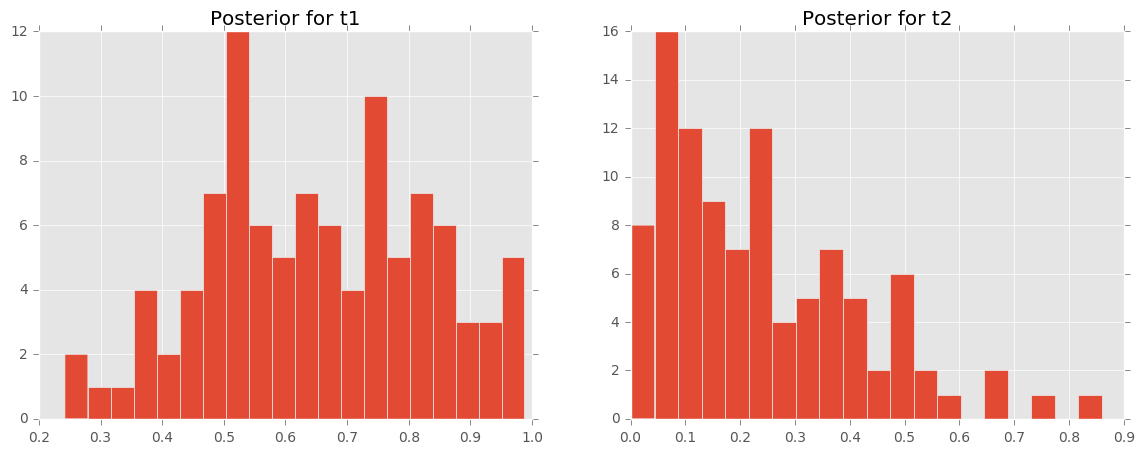

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(14,5));
ax[0].hist(t1_post, bins=20);
ax[0].set_title("Posterior for t1");
ax[1].hist(t2_post, bins=20);
ax[1].set_title("Posterior for t2");